# 앙상블(Ensemble) - 1. 보팅, 배깅, 랜덤포레스트

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score , cross_validate

import matplotlib.pyplot as plt 
import seaborn as sns

# 보팅( Voting Classifier)

### 개별 분류기의 성능과 보팅 분류기의 성능 비교

### 하드보팅 모델 학습 및 예측

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

In [3]:
# 위스콘식 유방암 데이터세트
from sklearn.datasets import load_breast_cancer

b_cancer = load_breast_cancer()
b_cancer.data.shape

(569, 30)

In [ ]:
# 데이터 살펴보기

* 로지스틱 회귀, KNN을 기반으로 한 소프트보팅 분류기

In [4]:
X = b_cancer.data
y = b_cancer.target

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=156)

In [5]:
#개별 분류기 모델 생성
lr_clf =LogisticRegression(max_iter=10000)
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt_clf = DecisionTreeClassifier(max_depth=3)

# 앙상블 분류기(보팅)
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('kNN',knn_clf),('DT',dt_clf)],voting='soft')

# 학습 , 예측, 평가
vo_clf.fit(X_train,y_train)

y_pred_test = vo_clf.predict(X_test)
test_score = accuracy_score(y_test,y_pred_test)
print(f"voting test score: {test_score}")

voting test score: 0.9473684210526315


In [6]:
## 이름 사용
lr_clf.__class__.__name__

'LogisticRegression'

In [7]:
# 각 모델별 test_Scor 생성
# voting 모델과 차이값을 알아보시오
## 대부분 앙상블의 점수가 좋게 나온다 (이 경우 특이 케이스)
clf_list = [lr_clf , knn_clf , dt_clf]

for clf in clf_list:
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.9649122807017544
KNeighborsClassifier 0.9385964912280702
DecisionTreeClassifier 0.956140350877193


# Random Forest : 와인 데이터셋

In [8]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


wine_kaggle = pd.read_csv('data/wine_dataset.csv')
wine = wine_kaggle[['alcohol','residual_sugar','pH']]
wine_kaggle['style'].replace('red', 0, inplace=True)
wine_kaggle['style'].replace('white', 1, inplace=True)

X=wine.values
y= wine_kaggle['style'].values


하이퍼 파라미터  
n_estimators: 모형(week learner)의 개수, 순차적으로 오류를 보정해 수가 많으면 성능이 일정   수준까지 높아질 수 있으나, 수행 시간이 오래 걸린다는 단점이 있음(디폴트는 100)  
min_samples_leaf: 말단 리프 노드의 최소한의 샘플 데이터 수, 디폴트 1  
max_depth: 트리의 최대 깊이, 디폴트 3  
max_features: 디폴트는 auto, If “auto”, then max_features=sqrt(n_features)  
즉, 피처가 4개면 분할을 위해 2개 참조 


In [9]:
# 데이터 분할 :test_size=0.2, random_state=42
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [10]:
# RandomForestClassifier 모델 구축, 학습 및 평가
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

print(f"train_score:{rf_clf.score(X_train,y_train)}")
print(f"test_score:{rf_clf.score(X_test,y_test)}")

train_score:0.996921300750433
test_score:0.8907692307692308


In [11]:
#분류 평가 리포트
from sklearn.metrics import confusion_matrix
y_pred = rf_clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

[[265  76]
 [ 66 893]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       341
           1       0.92      0.93      0.93       959

    accuracy                           0.89      1300
   macro avg       0.86      0.85      0.86      1300
weighted avg       0.89      0.89      0.89      1300



### 랜덤 포레스트 하이퍼파라미터 튜닝

In [12]:
# 과대적합이므로 그리드서치
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100,500],
    'max_depth':[6,8,10,12],
    'min_samples_split':[8,16,20],
    'min_samples_leaf' :[8,12,18]
}

gs = GridSearchCV(rf_clf,param_grid=params, cv=2 ,n_jobs=-1)
gs.fit(X_train,y_train)

gs.best_params_

{'max_depth': 12,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [13]:
print(f"train_score: {gs.best_estimator_.score(X_train,y_train)}")
print(f"train_score: {gs.best_estimator_.score(X_test,y_test)}")

train_score: 0.9072541851067923
train_score: 0.8692307692307693


* [참고] 트리 갯수 300개로 증가시킨후 학습 -> 별도의 테스트 데이터셋에서 예측 -> 성능측정

### 특성 중요도(feature importances)

In [14]:
### 값 순서대로 Alchol , Sugar , pH
fi = gs.best_estimator_.feature_importances_

In [15]:
f_importance = pd.Series(data =fi, index=wine.columns).sort_index(ascending=False)

<Axes: >

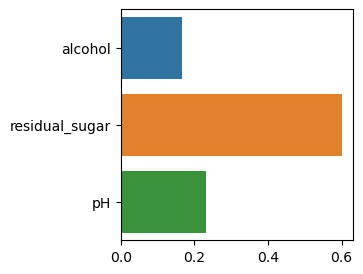

In [16]:
plt.figure(figsize=(3,3))
sns.barplot(x=fi, y=wine.columns)

# [실습]  사용자 행동 인식 데이터 세트 랜덤포레스트 분류하라
(기본 모델 -> 하이퍼파라미터 튜닝 -> 피처 중요도 시각화)

### 랜덤 포레스트 하이퍼 파라미터 튜닝

### 피처별 중요도 시각화

# 실습] 타이타닉 데이터셋 랜덤 포레스트 분류
기본 모델 - 하이퍼파라미터 튜닝 - 특성 중요도 시각화

### 하이퍼 파라미터

In [ ]:
RandomForestClassifier?

In [ ]:
# GridSearchCV()를 활용한 최적의 파라미터 찾기

### 특성 중요도

# 실습] 와인데이터셋 랜덤포레스트 분류하기
기본 모델 -> 튜닝 -> 점수 ->  특성 중요도 시각화